In [8]:
### 0. Ścieżki do plików CSV

"""
Ustawia wspólny katalog na wszystkie pliki CSV z tego notatnika.

OUTPUT_CSV_DIR – katalog na wyniki pośrednie (kandydaci na dc:subject itd.).
"""

from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path(".").resolve()


OUTPUT_CSV_DIR = PROJECT_ROOT / "outputs" / "csv"
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

LOGS_DIR = PROJECT_ROOT / "logs"
LOGS_DIR.mkdir(parents=True, exist_ok=True)
RUNLOG_PATH = LOGS_DIR / "runlog.jsonl"

### 1. Inicjalizacja YOLO-Medium i ścieżek

In [9]:
### 1. Inicjalizacja YOLO-Medium i ścieżek

from pathlib import Path
import torch
from ultralytics import YOLO

# urządzenie (Apple Silicon → mps; fallback → cpu)
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

# katalog z obrazami 
IMAGES_DIR = PROJECT_ROOT / "inputs"

# katalog na inne artefakty YOLO
YOLO_OUT_DIR = PROJECT_ROOT / "outputs" / "yolo_objects"
YOLO_OUT_DIR.mkdir(parents=True, exist_ok=True)

# wspólny katalog na CSV
OUTPUT_CSV_DIR = PROJECT_ROOT / "outputs" / "csv"
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)

# CSV z pełnymi detekcjami
OUTPUT_CSV = OUTPUT_CSV_DIR / "yolo_detections.csv"

# CSV z „subjects” uzgodnionymi z DC:subject (np. marka, typ)
SUBJECT_CSV = OUTPUT_CSV_DIR / "yolo_subjects.csv"

print("IMAGES_DIR:  ", IMAGES_DIR)
print("OUTPUT_CSV:  ", OUTPUT_CSV)
print("SUBJECT_CSV: ", SUBJECT_CSV)

# ładowanie modelu YOLO-Medium (COCO pretrained)
model = YOLO("yolov8m.pt")
model.to(device)
print("Załadowano YOLO-Medium (yolov8m.pt)")

Device: mps
IMAGES_DIR:   /Users/olga/MetaLogic/inputs
OUTPUT_CSV:   /Users/olga/MetaLogic/outputs/csv/yolo_detections.csv
SUBJECT_CSV:  /Users/olga/MetaLogic/outputs/csv/yolo_subjects.csv
Załadowano YOLO-Medium (yolov8m.pt)


### 2. Funkcja detekcji dla pojedynczego obrazu

In [10]:
### 2. Lista obrazów wejściowych

from pathlib import Path

IMAGE_ROOT = IMAGES_DIR

# lista plików graficznych (bez .DS_Store)
image_files = sorted([
    p for p in IMAGE_ROOT.iterdir()
    if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".tif", ".tiff"]
])

print("Liczba obrazów:", len(image_files))
if len(image_files) == 0:
    print("UWAGA: brak obrazów w folderze 'inputs/'")

Liczba obrazów: 74


### 3. Wizualizacja detekcji (rysowanie bounding boxów)

YOLO_PREVIEW_DIR: /Users/olga/MetaLogic/outputs/previews/yolo

0: 640x416 21 bottles, 153.4ms
Speed: 6.3ms preprocess, 153.4ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 416)


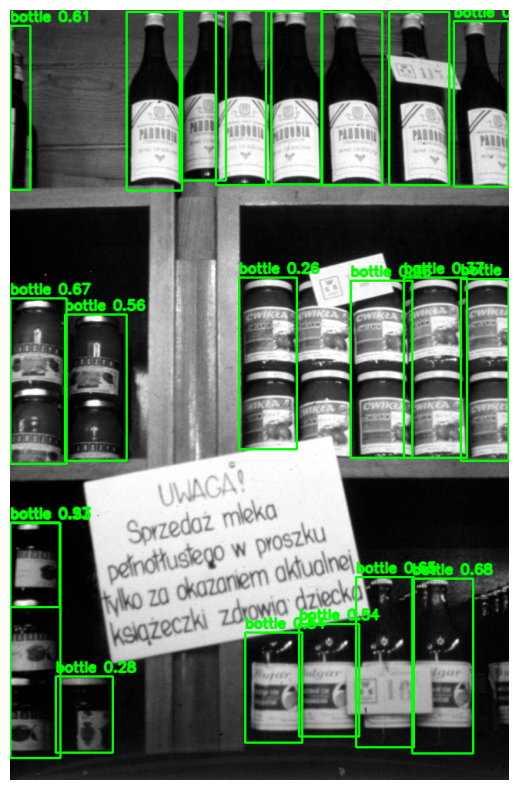

In [11]:
### Ktalog na miniatury

# katalog na miniatury z bounding boxami
YOLO_PREVIEW_DIR = PROJECT_ROOT / "outputs" / "previews" / "yolo"
YOLO_PREVIEW_DIR.mkdir(parents=True, exist_ok=True)

print("YOLO_PREVIEW_DIR:", YOLO_PREVIEW_DIR)

### 3. Wczytywanie modelu YOLO-Medium i funkcje pomocnicze

import torch
import numpy as np
from ultralytics import YOLO
import cv2
from PIL import Image

# Załaduj YOLO-Medium (yolov8m)
model = YOLO("yolov8m.pt")  # medium

# nazwy klas COCO:  {0: 'person', 1: 'bicycle', ...}
CLASS_NAMES = model.names

def run_yolo_on_image(img_path):
    """Wczytuje obraz i wykonuje detekcję YOLO-Medium."""
    img = Image.open(img_path).convert("RGB")
    results = model(img, conf=0.25)[0]
    detections = results.boxes
    return img, detections


def draw_detections(orig_img, detections):
    """Rysuje wykryte obiekty na obrazie."""
    img_np = np.array(orig_img).copy()

    for b in detections:
        cls_id = int(b.cls)
        conf = float(b.conf)
        x1, y1, x2, y2 = map(int, b.xyxy[0])

        # zielony box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

        label = f"{CLASS_NAMES[cls_id]} {conf:.2f}"
        cv2.putText(
            img_np,
            label,
            (x1, y1 - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

    return Image.fromarray(img_np)


# test jednego obrazu
test_img = image_files[0]
orig, dets = run_yolo_on_image(test_img)
vis = draw_detections(orig, dets)

plt.figure(figsize=(10, 10))
plt.imshow(vis)
plt.axis("off")
plt.show()

### 4. Batch YOLO-Medium inference → zapis wyników do CSV

In [12]:
### 4. Batch YOLO-Medium inference → zapis wyników do CSV

import pandas as pd
from tqdm import tqdm

OUTPUT_CSV = OUTPUT_CSV_DIR / "yolo_medium_results.csv"

records = []

for img_path in tqdm(image_files, desc="YOLO-Medium batch", ncols=90):
    try:
        orig, dets = run_yolo_on_image(img_path)
    except Exception:
        continue

    class_ids = [int(b.cls) for b in dets]
    class_names = [CLASS_NAMES[c] for c in class_ids]

    # zliczamy ile obiektów danej klasy
    counts = pd.Series(class_names).value_counts().to_dict()

    records.append({
        "file_path": str(img_path),
        "n_detections": len(class_names),
        "classes": class_names,
        "class_counts": counts,
    })
# zapis miniaturki z bounding boxami### 4. Batch YOLO-Medium inference → zapis wyników do CSV + miniatury

"""
    Uruchamia detekcję YOLO-Medium na wszystkich obrazach z IMAGE_ROOT.

    - Zapisuje pełne wyniki detekcji do CSV (OUTPUT_CSV).
    - Dla każdego obrazu zapisuje miniaturę z bounding boxami w YOLO_PREVIEW_DIR.

    IMAGE_ROOT       – katalog wejściowy z obrazami (Path)
    OUTPUT_CSV_DIR   – katalog na pliki CSV
    OUTPUT_CSV       – plik CSV z pełnymi wynikami detekcji
    YOLO_PREVIEW_DIR – katalog na miniatury z boxami
"""

import pandas as pd
from tqdm import tqdm

OUTPUT_CSV = OUTPUT_CSV_DIR / "yolo_detections.csv"

records = []

for img_path in tqdm(image_files, desc="YOLO-Medium batch", ncols=90):
    try:
        orig, dets = run_yolo_on_image(img_path)
    except Exception:
        continue

    class_ids = [int(b.cls) for b in dets]
    class_names = [CLASS_NAMES[c] for c in class_ids]

    # zliczamy ile obiektów danej klasy
    counts = pd.Series(class_names).value_counts().to_dict()

    records.append({
        "file_path": str(img_path),
        "n_detections": len(class_names),
        "classes": class_names,
        "class_counts": counts,
    })

    # zapis miniaturki z bounding boxami
    thumb = draw_detections(orig, dets)
    thumb.thumbnail((1200, 1200))  # maksymalny wymiar miniatury

    thumb_name = f"thumb_{img_path.stem}.jpg"
    thumb_path = YOLO_PREVIEW_DIR / thumb_name
    thumb.save(thumb_path, "JPEG")

df_yolo = pd.DataFrame(records)

df_yolo.to_csv(OUTPUT_CSV, index=False)
print("Zapisano wyniki:", OUTPUT_CSV)
print("Liczba obrazów przetworzonych:", len(df_yolo))

# zmniejszamy do max 350 px szerokości
thumb.thumbnail((1200, 1200))

thumb_name = f"thumb_{img_path.stem}.jpg"
thumb_path = YOLO_PREVIEW_DIR / thumb_name
thumb.save(thumb_path, "JPEG")

df_yolo = pd.DataFrame(records)

df_yolo.to_csv(OUTPUT_CSV, index=False)
print("Zapisano wyniki:", OUTPUT_CSV)
print("Liczba obrazów przetworzonych:", len(df_yolo))

YOLO-Medium batch:   0%|                                           | 0/74 [00:00<?, ?it/s]


0: 640x416 21 bottles, 130.6ms
Speed: 1.2ms preprocess, 130.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:   1%|▍                                  | 1/74 [00:00<00:10,  6.68it/s]


0: 480x640 16 persons, 1 tie, 138.3ms
Speed: 1.2ms preprocess, 138.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   3%|▉                                  | 2/74 [00:00<00:10,  6.63it/s]


0: 480x640 15 persons, 132.3ms
Speed: 1.5ms preprocess, 132.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   4%|█▍                                 | 3/74 [00:00<00:10,  6.72it/s]


0: 480x640 19 persons, 1 tie, 1 tennis racket, 132.4ms
Speed: 1.2ms preprocess, 132.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   5%|█▉                                 | 4/74 [00:00<00:10,  6.77it/s]


0: 480x640 12 persons, 1 backpack, 1 handbag, 1 potted plant, 132.4ms
Speed: 1.2ms preprocess, 132.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   7%|██▎                                | 5/74 [00:00<00:10,  6.81it/s]


0: 448x640 13 persons, 1 bench, 1 handbag, 136.6ms
Speed: 1.1ms preprocess, 136.6ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:   8%|██▊                                | 6/74 [00:00<00:10,  6.59it/s]


0: 448x640 4 persons, 1 dog, 1 handbag, 133.9ms
Speed: 1.0ms preprocess, 133.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:   9%|███▎                               | 7/74 [00:01<00:10,  6.49it/s]


0: 576x640 11 persons, 2 motorcycles, 167.6ms
Speed: 1.5ms preprocess, 167.6ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  11%|███▊                               | 8/74 [00:01<00:12,  5.46it/s]


0: 448x640 18 persons, 1 tie, 140.6ms
Speed: 1.0ms preprocess, 140.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  12%|████▎                              | 9/74 [00:01<00:11,  5.71it/s]


0: 448x640 17 persons, 5 cars, 3 buss, 1 backpack, 3 handbags, 137.1ms
Speed: 1.2ms preprocess, 137.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  14%|████▌                             | 10/74 [00:01<00:10,  5.93it/s]


0: 512x640 3 persons, 1 tie, 13 donuts, 5 cakes, 163.6ms
Speed: 1.6ms preprocess, 163.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  15%|█████                             | 11/74 [00:01<00:12,  5.09it/s]


0: 640x640 5 persons, 1 bicycle, 1 bowl, 197.8ms
Speed: 1.6ms preprocess, 197.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  16%|█████▌                            | 12/74 [00:02<00:12,  4.81it/s]


0: 640x448 9 persons, 2 cars, 1 airplane, 139.4ms
Speed: 1.1ms preprocess, 139.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  18%|█████▉                            | 13/74 [00:02<00:11,  5.20it/s]


0: 640x448 (no detections), 136.5ms
Speed: 1.1ms preprocess, 136.5ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  19%|██████▍                           | 14/74 [00:02<00:10,  5.55it/s]


0: 448x640 1 airplane, 135.0ms
Speed: 1.1ms preprocess, 135.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  20%|██████▉                           | 15/74 [00:02<00:10,  5.81it/s]


0: 640x544 (no detections), 195.0ms
Speed: 1.4ms preprocess, 195.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 544)


YOLO-Medium batch:  22%|███████▎                          | 16/74 [00:02<00:10,  5.40it/s]


0: 544x640 18 persons, 4 cars, 1 truck, 7 umbrellas, 1 handbag, 1 potted plant, 238.4ms
Speed: 2.4ms preprocess, 238.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  23%|███████▊                          | 17/74 [00:03<00:13,  4.26it/s]


0: 640x640 10 persons, 3 handbags, 195.8ms
Speed: 1.5ms preprocess, 195.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  24%|████████▎                         | 18/74 [00:03<00:13,  4.28it/s]


0: 448x640 15 persons, 13 cars, 3 toilets, 1 vase, 135.9ms
Speed: 1.1ms preprocess, 135.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  26%|████████▋                         | 19/74 [00:03<00:11,  4.77it/s]


0: 448x640 21 persons, 25 cars, 1 bus, 2 trucks, 135.6ms
Speed: 1.1ms preprocess, 135.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  27%|█████████▏                        | 20/74 [00:03<00:10,  5.20it/s]


0: 448x640 5 persons, 1 banana, 140.9ms
Speed: 1.3ms preprocess, 140.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  28%|█████████▋                        | 21/74 [00:03<00:10,  5.19it/s]


0: 448x640 4 persons, 2 cars, 1 truck, 1 dog, 184.0ms
Speed: 1.3ms preprocess, 184.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  30%|██████████                        | 22/74 [00:04<00:10,  5.11it/s]


0: 448x640 16 persons, 1 tie, 1 donut, 146.5ms
Speed: 1.2ms preprocess, 146.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  31%|██████████▌                       | 23/74 [00:04<00:09,  5.38it/s]


0: 512x640 9 persons, 200.8ms
Speed: 1.4ms preprocess, 200.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  32%|███████████                       | 24/74 [00:04<00:09,  5.11it/s]


0: 576x640 6 persons, 1 car, 1 dog, 1 sports ball, 2 cups, 170.4ms
Speed: 1.6ms preprocess, 170.4ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  34%|███████████▍                      | 25/74 [00:04<00:10,  4.76it/s]


0: 544x640 10 persons, 1 bicycle, 1 car, 4 benchs, 159.4ms
Speed: 1.5ms preprocess, 159.4ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  35%|███████████▉                      | 26/74 [00:04<00:10,  4.49it/s]


0: 544x640 5 persons, 1 bicycle, 4 benchs, 1 suitcase, 151.1ms
Speed: 1.5ms preprocess, 151.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  36%|████████████▍                     | 27/74 [00:05<00:10,  4.35it/s]


0: 608x640 4 persons, 2 handbags, 1 bottle, 2 cell phones, 174.6ms
Speed: 1.6ms preprocess, 174.6ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  38%|████████████▊                     | 28/74 [00:05<00:10,  4.18it/s]


0: 512x640 9 persons, 1 car, 3 buss, 1 truck, 199.4ms
Speed: 1.5ms preprocess, 199.4ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  39%|█████████████▎                    | 29/74 [00:05<00:11,  3.86it/s]


0: 640x608 6 persons, 1 bus, 235.8ms
Speed: 1.8ms preprocess, 235.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:  41%|█████████████▊                    | 30/74 [00:06<00:11,  3.70it/s]


0: 640x512 1 person, 197.5ms
Speed: 1.5ms preprocess, 197.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  42%|██████████████▏                   | 31/74 [00:06<00:11,  3.72it/s]


0: 640x480 2 persons, 1 bicycle, 169.9ms
Speed: 1.4ms preprocess, 169.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  43%|██████████████▋                   | 32/74 [00:06<00:10,  4.11it/s]


0: 512x640 1 person, 1 bear, 1 sink, 1 scissors, 239.4ms
Speed: 1.5ms preprocess, 239.4ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  45%|███████████████▏                  | 33/74 [00:06<00:11,  3.59it/s]


0: 576x640 3 persons, 1 tie, 1 suitcase, 220.6ms
Speed: 2.4ms preprocess, 220.6ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  46%|███████████████▌                  | 34/74 [00:07<00:11,  3.50it/s]


0: 640x640 7 persons, 1 handbag, 1 suitcase, 195.4ms
Speed: 1.7ms preprocess, 195.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  47%|████████████████                  | 35/74 [00:07<00:11,  3.54it/s]


0: 640x640 10 persons, 1 handbag, 191.2ms
Speed: 1.6ms preprocess, 191.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  49%|████████████████▌                 | 36/74 [00:07<00:10,  3.76it/s]


0: 640x640 4 persons, 1 fork, 1 bowl, 1 chair, 184.3ms
Speed: 1.6ms preprocess, 184.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  50%|█████████████████                 | 37/74 [00:07<00:09,  3.96it/s]


0: 640x640 1 person, 1 umbrella, 3 bottles, 2 clocks, 186.4ms
Speed: 1.7ms preprocess, 186.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  51%|█████████████████▍                | 38/74 [00:08<00:08,  4.06it/s]


0: 640x640 10 persons, 3 bicycles, 1 bottle, 230.6ms
Speed: 1.9ms preprocess, 230.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  53%|█████████████████▉                | 39/74 [00:08<00:09,  3.79it/s]


0: 480x640 1 sheep, 145.4ms
Speed: 1.2ms preprocess, 145.4ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  54%|██████████████████▍               | 40/74 [00:08<00:07,  4.33it/s]


0: 640x480 4 persons, 1 dog, 1 sheep, 1 sports ball, 148.0ms
Speed: 1.3ms preprocess, 148.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  55%|██████████████████▊               | 41/74 [00:08<00:06,  4.76it/s]


0: 640x640 6 persons, 198.8ms
Speed: 1.7ms preprocess, 198.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  57%|███████████████████▎              | 42/74 [00:08<00:06,  4.61it/s]


0: 640x480 2 persons, 1 tie, 8 bottles, 238.5ms
Speed: 1.3ms preprocess, 238.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  58%|███████████████████▊              | 43/74 [00:09<00:07,  4.13it/s]


0: 512x640 8 persons, 2 sheeps, 191.5ms
Speed: 1.6ms preprocess, 191.5ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  59%|████████████████████▏             | 44/74 [00:09<00:07,  4.05it/s]


0: 640x512 3 persons, 213.8ms
Speed: 1.5ms preprocess, 213.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  61%|████████████████████▋             | 45/74 [00:09<00:06,  4.15it/s]


0: 480x640 3 persons, 1 train, 168.8ms
Speed: 1.5ms preprocess, 168.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  62%|█████████████████████▏            | 46/74 [00:09<00:06,  4.50it/s]


0: 640x416 1 person, 140.4ms
Speed: 1.3ms preprocess, 140.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:  64%|█████████████████████▌            | 47/74 [00:10<00:05,  4.94it/s]


0: 416x640 3 persons, 1 horse, 133.5ms
Speed: 1.0ms preprocess, 133.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  65%|██████████████████████            | 48/74 [00:10<00:04,  5.39it/s]


0: 608x640 2 persons, 179.5ms
Speed: 1.6ms preprocess, 179.5ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  66%|██████████████████████▌           | 49/74 [00:10<00:05,  4.85it/s]


0: 640x448 1 person, 151.2ms
Speed: 1.6ms preprocess, 151.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  68%|██████████████████████▉           | 50/74 [00:10<00:04,  5.17it/s]


0: 512x640 2 persons, 2 horses, 171.6ms
Speed: 1.4ms preprocess, 171.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  69%|███████████████████████▍          | 51/74 [00:10<00:04,  5.22it/s]


0: 576x640 4 persons, 3 cups, 1 bowl, 164.0ms
Speed: 1.6ms preprocess, 164.0ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  70%|███████████████████████▉          | 52/74 [00:11<00:04,  4.64it/s]


0: 576x640 3 persons, 2 birds, 2 cups, 1 bowl, 163.3ms
Speed: 1.6ms preprocess, 163.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  72%|████████████████████████▎         | 53/74 [00:11<00:04,  4.33it/s]


0: 512x640 2 persons, 2 suitcases, 4 cups, 1 tv, 166.8ms
Speed: 1.8ms preprocess, 166.8ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  73%|████████████████████████▊         | 54/74 [00:11<00:04,  4.02it/s]


0: 640x640 2 persons, 1 bed, 198.2ms
Speed: 1.8ms preprocess, 198.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  74%|█████████████████████████▎        | 55/74 [00:11<00:04,  4.01it/s]


0: 640x640 2 persons, 1 donut, 365.6ms
Speed: 1.8ms preprocess, 365.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  76%|█████████████████████████▋        | 56/74 [00:12<00:05,  3.33it/s]


0: 640x640 2 persons, 1 tie, 2 bowls, 1 laptop, 1 oven, 2 books, 236.2ms
Speed: 4.7ms preprocess, 236.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  77%|██████████████████████████▏       | 57/74 [00:12<00:05,  3.30it/s]


0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 199.2ms
Speed: 1.9ms preprocess, 199.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  78%|██████████████████████████▋       | 58/74 [00:12<00:04,  3.39it/s]


0: 640x640 7 persons, 2 handbags, 187.2ms
Speed: 1.7ms preprocess, 187.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  80%|███████████████████████████       | 59/74 [00:13<00:04,  3.48it/s]


0: 640x640 1 person, 13 donuts, 197.5ms
Speed: 1.7ms preprocess, 197.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  81%|███████████████████████████▌      | 60/74 [00:13<00:03,  3.73it/s]


0: 416x640 18 persons, 1 stop sign, 1 dog, 1 umbrella, 2 handbags, 2 ties, 144.5ms
Speed: 1.2ms preprocess, 144.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  82%|████████████████████████████      | 61/74 [00:13<00:03,  4.16it/s]


0: 640x640 2 persons, 1 tie, 1 pizza, 2 chairs, 196.6ms
Speed: 1.6ms preprocess, 196.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  84%|████████████████████████████▍     | 62/74 [00:13<00:02,  4.27it/s]


0: 512x640 3 persons, 1 motorcycle, 188.7ms
Speed: 1.7ms preprocess, 188.7ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  85%|████████████████████████████▉     | 63/74 [00:14<00:02,  4.00it/s]


0: 640x640 1 person, 1 baseball bat, 194.0ms
Speed: 1.6ms preprocess, 194.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  86%|█████████████████████████████▍    | 64/74 [00:14<00:02,  4.21it/s]


0: 448x640 13 persons, 3 handbags, 1 suitcase, 143.9ms
Speed: 1.2ms preprocess, 143.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  88%|█████████████████████████████▊    | 65/74 [00:14<00:01,  4.70it/s]


0: 512x640 16 persons, 1 traffic light, 2 umbrellas, 3 handbags, 172.2ms
Speed: 1.3ms preprocess, 172.2ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  89%|██████████████████████████████▎   | 66/74 [00:14<00:01,  4.89it/s]


0: 448x640 6 persons, 2 traffic lights, 2 umbrellas, 1 cell phone, 139.3ms
Speed: 1.1ms preprocess, 139.3ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  91%|██████████████████████████████▊   | 67/74 [00:14<00:01,  5.33it/s]


0: 448x640 2 persons, 1 backpack, 145.0ms
Speed: 1.1ms preprocess, 145.0ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  92%|███████████████████████████████▏  | 68/74 [00:14<00:01,  5.63it/s]


0: 608x640 4 persons, 1 backpack, 2 handbags, 1 bottle, 2 cell phones, 183.4ms
Speed: 1.5ms preprocess, 183.4ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  93%|███████████████████████████████▋  | 69/74 [00:15<00:00,  5.45it/s]


0: 608x640 3 persons, 1 car, 1 truck, 2 umbrellas, 2 handbags, 1 potted plant, 1 vase, 170.5ms
Speed: 1.6ms preprocess, 170.5ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  95%|████████████████████████████████▏ | 70/74 [00:15<00:00,  5.43it/s]


0: 640x448 3 persons, 1 bench, 142.5ms
Speed: 1.3ms preprocess, 142.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  96%|████████████████████████████████▌ | 71/74 [00:15<00:00,  5.66it/s]


0: 640x448 1 person, 1 baseball bat, 148.4ms
Speed: 1.1ms preprocess, 148.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  97%|█████████████████████████████████ | 72/74 [00:15<00:00,  5.83it/s]


0: 640x448 3 persons, 144.2ms
Speed: 1.3ms preprocess, 144.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  99%|█████████████████████████████████▌| 73/74 [00:15<00:00,  5.94it/s]


0: 640x448 3 persons, 3 chairs, 140.0ms
Speed: 1.2ms preprocess, 140.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:   0%|                                           | 0/74 [00:00<?, ?it/s]


0: 640x416 21 bottles, 124.1ms
Speed: 1.0ms preprocess, 124.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:   1%|▍                                  | 1/74 [00:00<00:10,  7.18it/s]


0: 480x640 16 persons, 1 tie, 136.9ms
Speed: 1.1ms preprocess, 136.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   3%|▉                                  | 2/74 [00:00<00:11,  6.15it/s]


0: 480x640 15 persons, 136.4ms
Speed: 1.2ms preprocess, 136.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   4%|█▍                                 | 3/74 [00:00<00:11,  6.19it/s]


0: 480x640 19 persons, 1 tie, 1 tennis racket, 146.9ms
Speed: 1.2ms preprocess, 146.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   5%|█▉                                 | 4/74 [00:00<00:11,  6.13it/s]


0: 480x640 12 persons, 1 backpack, 1 handbag, 1 potted plant, 147.5ms
Speed: 1.2ms preprocess, 147.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:   7%|██▎                                | 5/74 [00:00<00:11,  6.10it/s]


0: 448x640 13 persons, 1 bench, 1 handbag, 134.7ms
Speed: 1.2ms preprocess, 134.7ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:   8%|██▊                                | 6/74 [00:00<00:11,  6.10it/s]


0: 448x640 4 persons, 1 dog, 1 handbag, 137.4ms
Speed: 1.1ms preprocess, 137.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:   9%|███▎                               | 7/74 [00:01<00:11,  6.07it/s]


0: 576x640 11 persons, 2 motorcycles, 176.2ms
Speed: 1.6ms preprocess, 176.2ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  11%|███▊                               | 8/74 [00:01<00:13,  4.91it/s]


0: 448x640 18 persons, 1 tie, 142.9ms
Speed: 1.1ms preprocess, 142.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  12%|████▎                              | 9/74 [00:01<00:12,  5.22it/s]


0: 448x640 17 persons, 5 cars, 3 buss, 1 backpack, 3 handbags, 133.9ms
Speed: 1.1ms preprocess, 133.9ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  14%|████▌                             | 10/74 [00:01<00:11,  5.54it/s]


0: 512x640 3 persons, 1 tie, 13 donuts, 5 cakes, 227.2ms
Speed: 1.8ms preprocess, 227.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  15%|█████                             | 11/74 [00:02<00:16,  3.81it/s]


0: 640x640 5 persons, 1 bicycle, 1 bowl, 222.0ms
Speed: 1.6ms preprocess, 222.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  16%|█████▌                            | 12/74 [00:02<00:17,  3.58it/s]


0: 640x448 9 persons, 2 cars, 1 airplane, 140.2ms
Speed: 1.3ms preprocess, 140.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  18%|█████▉                            | 13/74 [00:02<00:14,  4.10it/s]


0: 640x448 (no detections), 171.2ms
Speed: 1.1ms preprocess, 171.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  19%|██████▍                           | 14/74 [00:02<00:13,  4.38it/s]


0: 448x640 1 airplane, 173.5ms
Speed: 1.9ms preprocess, 173.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  20%|██████▉                           | 15/74 [00:03<00:12,  4.57it/s]


0: 640x544 (no detections), 244.7ms
Speed: 2.7ms preprocess, 244.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


YOLO-Medium batch:  22%|███████▎                          | 16/74 [00:03<00:13,  4.18it/s]


0: 544x640 18 persons, 4 cars, 1 truck, 7 umbrellas, 1 handbag, 1 potted plant, 176.4ms
Speed: 1.8ms preprocess, 176.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  23%|███████▊                          | 17/74 [00:03<00:15,  3.79it/s]


0: 640x640 10 persons, 3 handbags, 233.2ms
Speed: 1.6ms preprocess, 233.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  24%|████████▎                         | 18/74 [00:03<00:15,  3.73it/s]


0: 448x640 15 persons, 13 cars, 3 toilets, 1 vase, 182.8ms
Speed: 1.5ms preprocess, 182.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  26%|████████▋                         | 19/74 [00:04<00:13,  4.00it/s]


0: 448x640 21 persons, 25 cars, 1 bus, 2 trucks, 158.1ms
Speed: 1.2ms preprocess, 158.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  27%|█████████▏                        | 20/74 [00:04<00:12,  4.35it/s]


0: 448x640 5 persons, 1 banana, 135.8ms
Speed: 1.3ms preprocess, 135.8ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  28%|█████████▋                        | 21/74 [00:04<00:11,  4.45it/s]


0: 448x640 4 persons, 2 cars, 1 truck, 1 dog, 131.9ms
Speed: 1.1ms preprocess, 131.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  30%|██████████                        | 22/74 [00:04<00:10,  4.92it/s]


0: 448x640 16 persons, 1 tie, 1 donut, 132.3ms
Speed: 1.0ms preprocess, 132.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  31%|██████████▌                       | 23/74 [00:04<00:09,  5.33it/s]


0: 512x640 9 persons, 165.2ms
Speed: 1.2ms preprocess, 165.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  32%|███████████                       | 24/74 [00:05<00:09,  5.21it/s]


0: 576x640 6 persons, 1 car, 1 dog, 1 sports ball, 2 cups, 189.8ms
Speed: 1.7ms preprocess, 189.8ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  34%|███████████▍                      | 25/74 [00:05<00:10,  4.48it/s]


0: 544x640 10 persons, 1 bicycle, 1 car, 4 benchs, 150.8ms
Speed: 1.5ms preprocess, 150.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  35%|███████████▉                      | 26/74 [00:05<00:11,  4.17it/s]


0: 544x640 5 persons, 1 bicycle, 4 benchs, 1 suitcase, 160.3ms
Speed: 1.6ms preprocess, 160.3ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


YOLO-Medium batch:  36%|████████████▍                     | 27/74 [00:05<00:12,  3.91it/s]


0: 608x640 4 persons, 2 handbags, 1 bottle, 2 cell phones, 180.9ms
Speed: 1.8ms preprocess, 180.9ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  38%|████████████▊                     | 28/74 [00:06<00:12,  3.75it/s]


0: 512x640 9 persons, 1 car, 3 buss, 1 truck, 164.5ms
Speed: 1.5ms preprocess, 164.5ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  39%|█████████████▎                    | 29/74 [00:06<00:12,  3.62it/s]


0: 640x608 6 persons, 1 bus, 179.4ms
Speed: 1.8ms preprocess, 179.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 608)


YOLO-Medium batch:  41%|█████████████▊                    | 30/74 [00:06<00:11,  3.67it/s]


0: 640x512 1 person, 181.7ms
Speed: 1.4ms preprocess, 181.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  42%|██████████████▏                   | 31/74 [00:07<00:11,  3.71it/s]


0: 640x480 2 persons, 1 bicycle, 145.2ms
Speed: 1.4ms preprocess, 145.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  43%|██████████████▋                   | 32/74 [00:07<00:10,  4.16it/s]


0: 512x640 1 person, 1 bear, 1 sink, 1 scissors, 186.2ms
Speed: 1.6ms preprocess, 186.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  45%|███████████████▏                  | 33/74 [00:07<00:11,  3.73it/s]


0: 576x640 3 persons, 1 tie, 1 suitcase, 184.3ms
Speed: 1.8ms preprocess, 184.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  46%|███████████████▌                  | 34/74 [00:07<00:10,  3.65it/s]


0: 640x640 7 persons, 1 handbag, 1 suitcase, 183.2ms
Speed: 1.8ms preprocess, 183.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  47%|████████████████                  | 35/74 [00:08<00:10,  3.59it/s]


0: 640x640 10 persons, 1 handbag, 169.8ms
Speed: 1.5ms preprocess, 169.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  49%|████████████████▌                 | 36/74 [00:08<00:09,  3.87it/s]


0: 640x640 4 persons, 1 fork, 1 bowl, 1 chair, 169.4ms
Speed: 1.5ms preprocess, 169.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  50%|█████████████████                 | 37/74 [00:08<00:09,  4.11it/s]


0: 640x640 1 person, 1 umbrella, 3 bottles, 2 clocks, 196.9ms
Speed: 1.7ms preprocess, 196.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  51%|█████████████████▍                | 38/74 [00:08<00:09,  4.00it/s]


0: 640x640 10 persons, 3 bicycles, 1 bottle, 166.9ms
Speed: 1.7ms preprocess, 166.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  53%|█████████████████▉                | 39/74 [00:09<00:08,  3.94it/s]


0: 480x640 1 sheep, 128.8ms
Speed: 1.1ms preprocess, 128.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  54%|██████████████████▍               | 40/74 [00:09<00:07,  4.55it/s]


0: 640x480 4 persons, 1 dog, 1 sheep, 1 sports ball, 126.1ms
Speed: 1.3ms preprocess, 126.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  55%|██████████████████▊               | 41/74 [00:09<00:06,  5.01it/s]


0: 640x640 6 persons, 212.0ms
Speed: 1.5ms preprocess, 212.0ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  57%|███████████████████▎              | 42/74 [00:09<00:06,  4.67it/s]


0: 640x480 2 persons, 1 tie, 8 bottles, 125.4ms
Speed: 1.4ms preprocess, 125.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


YOLO-Medium batch:  58%|███████████████████▊              | 43/74 [00:09<00:06,  4.70it/s]


0: 512x640 8 persons, 2 sheeps, 148.0ms
Speed: 1.4ms preprocess, 148.0ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  59%|████████████████████▏             | 44/74 [00:10<00:06,  4.55it/s]


0: 640x512 3 persons, 154.7ms
Speed: 1.3ms preprocess, 154.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


YOLO-Medium batch:  61%|████████████████████▋             | 45/74 [00:10<00:06,  4.80it/s]


0: 480x640 3 persons, 1 train, 128.5ms
Speed: 1.2ms preprocess, 128.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


YOLO-Medium batch:  62%|█████████████████████▏            | 46/74 [00:10<00:05,  5.32it/s]


0: 640x416 1 person, 115.4ms
Speed: 1.1ms preprocess, 115.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


YOLO-Medium batch:  64%|█████████████████████▌            | 47/74 [00:10<00:04,  5.72it/s]


0: 416x640 3 persons, 1 horse, 111.6ms
Speed: 1.1ms preprocess, 111.6ms inference, 0.3ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  65%|██████████████████████            | 48/74 [00:10<00:04,  6.24it/s]


0: 608x640 2 persons, 153.5ms
Speed: 1.6ms preprocess, 153.5ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  66%|██████████████████████▌           | 49/74 [00:10<00:04,  5.35it/s]


0: 640x448 1 person, 122.7ms
Speed: 1.2ms preprocess, 122.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  68%|██████████████████████▉           | 50/74 [00:11<00:04,  5.69it/s]


0: 512x640 2 persons, 2 horses, 149.1ms
Speed: 1.4ms preprocess, 149.1ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  69%|███████████████████████▍          | 51/74 [00:11<00:03,  5.77it/s]


0: 576x640 4 persons, 3 cups, 1 bowl, 148.3ms
Speed: 1.5ms preprocess, 148.3ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  70%|███████████████████████▉          | 52/74 [00:11<00:04,  4.89it/s]


0: 576x640 3 persons, 2 birds, 2 cups, 1 bowl, 157.3ms
Speed: 1.7ms preprocess, 157.3ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


YOLO-Medium batch:  72%|████████████████████████▎         | 53/74 [00:11<00:04,  4.35it/s]


0: 512x640 2 persons, 2 suitcases, 4 cups, 1 tv, 147.7ms
Speed: 1.4ms preprocess, 147.7ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  73%|████████████████████████▊         | 54/74 [00:12<00:04,  4.02it/s]


0: 640x640 2 persons, 1 bed, 170.5ms
Speed: 1.7ms preprocess, 170.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  74%|█████████████████████████▎        | 55/74 [00:12<00:04,  4.04it/s]


0: 640x640 2 persons, 1 donut, 170.5ms
Speed: 1.6ms preprocess, 170.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  76%|█████████████████████████▋        | 56/74 [00:12<00:04,  4.07it/s]


0: 640x640 2 persons, 1 tie, 2 bowls, 1 laptop, 1 oven, 2 books, 197.7ms
Speed: 1.7ms preprocess, 197.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  77%|██████████████████████████▏       | 57/74 [00:12<00:04,  3.94it/s]


0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 176.4ms
Speed: 1.7ms preprocess, 176.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  78%|██████████████████████████▋       | 58/74 [00:13<00:03,  4.13it/s]


0: 640x640 7 persons, 2 handbags, 169.5ms
Speed: 1.7ms preprocess, 169.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  80%|███████████████████████████       | 59/74 [00:13<00:03,  3.98it/s]


0: 640x640 1 person, 13 donuts, 178.7ms
Speed: 1.6ms preprocess, 178.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  81%|███████████████████████████▌      | 60/74 [00:13<00:03,  4.20it/s]


0: 416x640 18 persons, 1 stop sign, 1 dog, 1 umbrella, 2 handbags, 2 ties, 112.8ms
Speed: 1.1ms preprocess, 112.8ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


YOLO-Medium batch:  82%|████████████████████████████      | 61/74 [00:13<00:02,  4.76it/s]


0: 640x640 2 persons, 1 tie, 1 pizza, 2 chairs, 172.3ms
Speed: 1.5ms preprocess, 172.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  84%|████████████████████████████▍     | 62/74 [00:13<00:02,  4.83it/s]


0: 512x640 3 persons, 1 motorcycle, 152.3ms
Speed: 2.1ms preprocess, 152.3ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  85%|████████████████████████████▉     | 63/74 [00:14<00:02,  4.44it/s]


0: 640x640 1 person, 1 baseball bat, 181.2ms
Speed: 1.7ms preprocess, 181.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


YOLO-Medium batch:  86%|█████████████████████████████▍    | 64/74 [00:14<00:02,  4.60it/s]


0: 448x640 13 persons, 3 handbags, 1 suitcase, 120.4ms
Speed: 1.2ms preprocess, 120.4ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  88%|█████████████████████████████▊    | 65/74 [00:14<00:01,  5.18it/s]


0: 512x640 16 persons, 1 traffic light, 2 umbrellas, 3 handbags, 149.3ms
Speed: 1.2ms preprocess, 149.3ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


YOLO-Medium batch:  89%|██████████████████████████████▎   | 66/74 [00:14<00:01,  5.40it/s]


0: 448x640 6 persons, 2 traffic lights, 2 umbrellas, 1 cell phone, 120.3ms
Speed: 1.2ms preprocess, 120.3ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  91%|██████████████████████████████▊   | 67/74 [00:14<00:01,  5.91it/s]


0: 448x640 2 persons, 1 backpack, 119.5ms
Speed: 1.2ms preprocess, 119.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


YOLO-Medium batch:  92%|███████████████████████████████▏  | 68/74 [00:14<00:00,  6.33it/s]


0: 608x640 4 persons, 1 backpack, 2 handbags, 1 bottle, 2 cell phones, 154.9ms
Speed: 1.4ms preprocess, 154.9ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  93%|███████████████████████████████▋  | 69/74 [00:15<00:00,  6.17it/s]


0: 608x640 3 persons, 1 car, 1 truck, 2 umbrellas, 2 handbags, 1 potted plant, 1 vase, 154.5ms
Speed: 1.5ms preprocess, 154.5ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


YOLO-Medium batch:  95%|████████████████████████████████▏ | 70/74 [00:15<00:00,  6.05it/s]


0: 640x448 3 persons, 1 bench, 120.9ms
Speed: 1.2ms preprocess, 120.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  96%|████████████████████████████████▌ | 71/74 [00:15<00:00,  6.20it/s]


0: 640x448 1 person, 1 baseball bat, 151.1ms
Speed: 1.1ms preprocess, 151.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  97%|█████████████████████████████████ | 72/74 [00:15<00:00,  6.15it/s]


0: 640x448 3 persons, 132.8ms
Speed: 1.3ms preprocess, 132.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch:  99%|█████████████████████████████████▌| 73/74 [00:15<00:00,  6.14it/s]


0: 640x448 3 persons, 3 chairs, 120.6ms
Speed: 1.2ms preprocess, 120.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


YOLO-Medium batch: 100%|██████████████████████████████████| 74/74 [00:15<00:00,  4.66it/s]

Zapisano wyniki: /Users/olga/MetaLogic/outputs/csv/yolo_detections.csv
Liczba obrazów przetworzonych: 74
Zapisano wyniki: /Users/olga/MetaLogic/outputs/csv/yolo_detections.csv
Liczba obrazów przetworzonych: 74


### 5. Podsumowanie detekcji + wizualizacja 5 przykładów

=== Podsumowanie detekcji w całym folderze ===
person: 484
car: 56
bottle: 35
handbag: 29
donut: 28
umbrella: 15
cup: 11
tie: 11
bench: 10
bus: 8
bicycle: 7
bowl: 6
chair: 6
truck: 6
suitcase: 6
cake: 5
dog: 5
cell phone: 5
backpack: 4
sheep: 4
horse: 3
clock: 3
traffic light: 3
motorcycle: 3
toilet: 3
potted plant: 3
airplane: 2
baseball bat: 2
book: 2
bird: 2
sports ball: 2
vase: 2
tennis racket: 1
fork: 1
train: 1
banana: 1
scissors: 1
tv: 1
bed: 1
bear: 1
oven: 1
laptop: 1
stop sign: 1
pizza: 1
sink: 1

Wybrane przykładowe obrazy: ['/Users/olga/MetaLogic/inputs/0119.jpg', '/Users/olga/MetaLogic/inputs/0282.jpg', '/Users/olga/MetaLogic/inputs/0117.jpg', '/Users/olga/MetaLogic/inputs/0115.jpg', '/Users/olga/MetaLogic/inputs/0077.jpg']

0: 448x640 21 persons, 25 cars, 1 bus, 2 trucks, 136.1ms
Speed: 1.1ms preprocess, 136.1ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 29 persons, 1 car, 1 handbag, 1 clock, 202.0ms
Speed: 1.5ms preprocess, 202.0ms infer

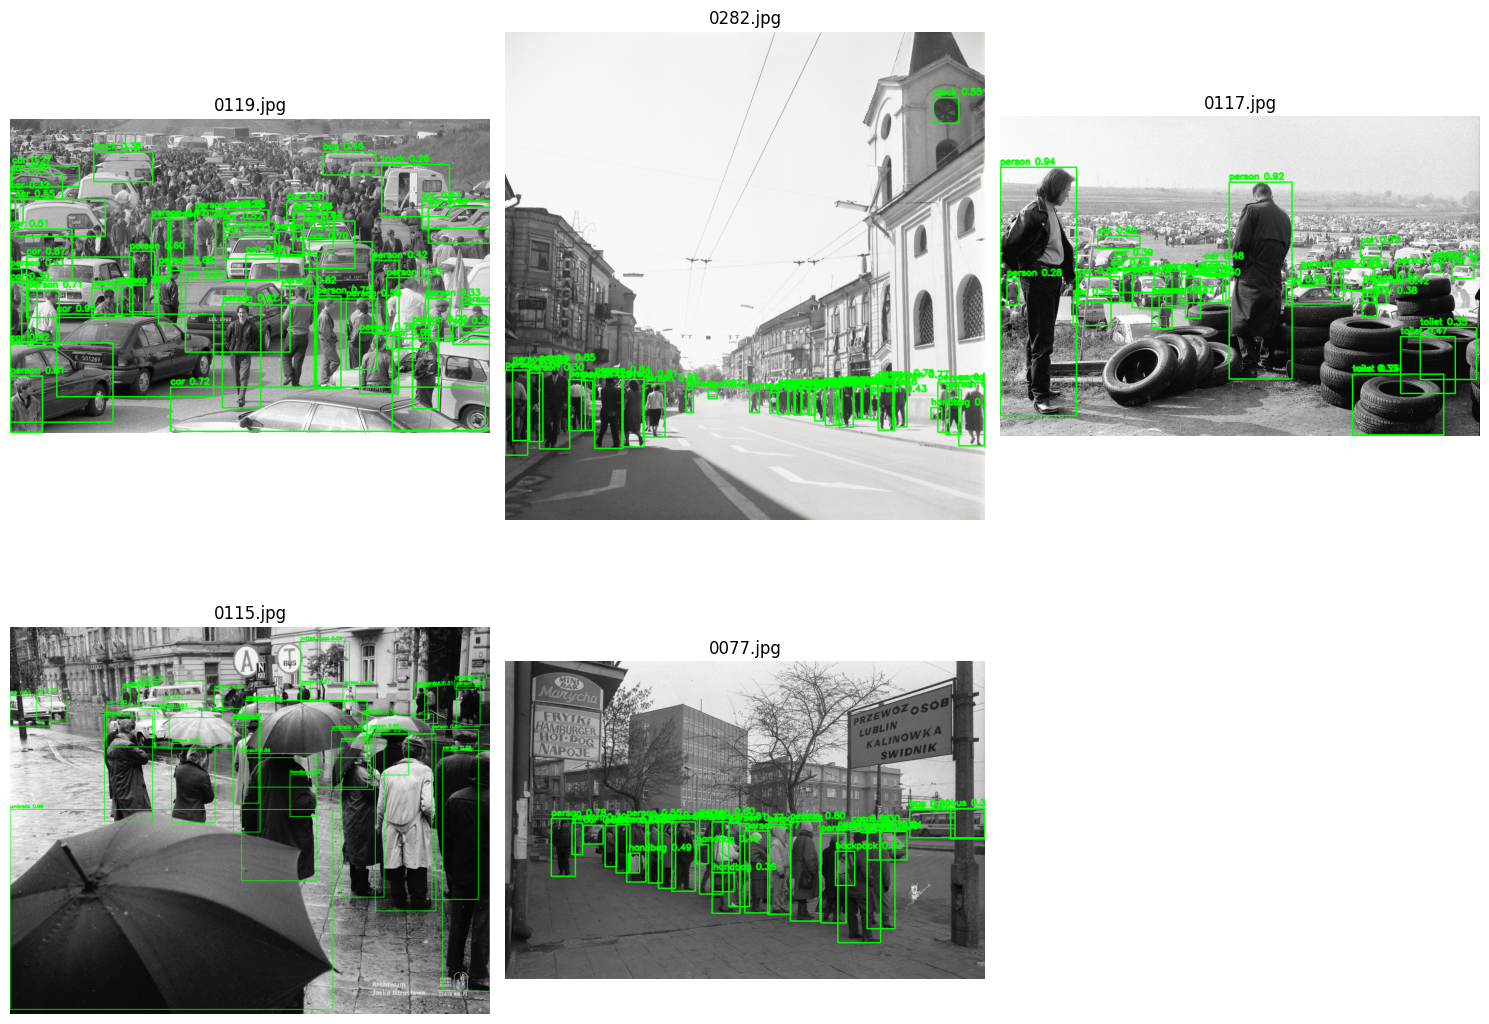

In [13]:
### 5. Podsumowanie detekcji + wizualizacja 5 przykładów

import matplotlib.pyplot as plt
import numpy as np

# --- globalne podsumowanie klas ---
all_counts = {}

for counts in df_yolo["class_counts"]:
    for cls, n in counts.items():
        all_counts[cls] = all_counts.get(cls, 0) + n

summary = pd.Series(all_counts).sort_values(ascending=False)

print("=== Podsumowanie detekcji w całym folderze ===")
for cls, n in summary.items():
    print(f"{cls}: {n}")

# --- wybieramy 5 obrazów z największą liczbą detekcji ---
examples = (
    df_yolo.sort_values("n_detections", ascending=False)
           .head(5)
)["file_path"].tolist()

print("\nWybrane przykładowe obrazy:", examples)

# --- wizualizacja ---
plt.figure(figsize=(15, 12))

for i, img_path in enumerate(examples, start=1):
    orig, dets = run_yolo_on_image(img_path)
    vis = draw_detections(orig, dets)

    plt.subplot(2, 3, i)
    plt.imshow(vis)
    plt.title(Path(img_path).name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### X. Eksport wykrytych obiektów do CSV

In [14]:
### X. Sugestie subject (PL/EN) na podstawie YOLO i eksport do CSV

import pandas as pd
from ast import literal_eval

# plik z batchowym wynikiem YOLO (komórka 4)
RESULTS_CSV = OUTPUT_CSV_DIR / "yolo_medium_results.csv"

# ============================
# SŁOWNIK EN → PL DLA KLAS YOLO
# (rozszerzysz w razie potrzeby)
# ============================
CLASS_PL = {
    "person": "osoba",
    "car": "samochód",
    "bicycle": "rower",
    "bus": "autobus",
    "truck": "ciężarówka",
    "train": "pociąg",
    "motorcycle": "motocykl",
    "bench": "ławka",
    "traffic light": "sygnalizator świetlny",
    "stop sign": "znak stop",
    "backpack": "plecak",
    "handbag": "torebka",
    "bottle": "butelka",
    "potted plant": "roślina w doniczce",
    "tennis racket": "rakieta tenisowa",
    # dopisuj kolejne klasy wg potrzeb
}

# 1) wczytanie wyników YOLO (jeśli df_yolo nie jest w pamięci)
if "df_yolo" not in globals():
    if not RESULTS_CSV.exists():
        raise FileNotFoundError(f"Brak pliku: {RESULTS_CSV}")
    df_yolo = pd.read_csv(
        RESULTS_CSV,
        converters={
            "classes": literal_eval,      # listy klas
            "class_counts": literal_eval  # słowniki {klasa: liczba}
        }
    )

# 2) funkcja: listę klas EN → subject_en + subject_pl
def classes_to_subjects(class_list):
    if not isinstance(class_list, list):
        return pd.Series({"subject_en": "", "subject_pl": ""})

    unique_en = sorted(set(class_list))
    subject_en = "; ".join(unique_en)

    pl_names = [CLASS_PL[c] for c in unique_en if c in CLASS_PL]
    subject_pl = "; ".join(pl_names) if pl_names else ""

    return pd.Series({"subject_en": subject_en, "subject_pl": subject_pl})

# 3) agregacja: jedno zdjęcie → jedna para subject_en / subject_pl
df_subj = df_yolo[["file_path", "classes"]].copy()
subj_cols = df_subj["classes"].apply(classes_to_subjects)
df_subj = pd.concat([df_subj["file_path"], subj_cols], axis=1)

# 4) zapis CSV
SUBJECT_CSV = OUTPUT_CSV_DIR / "yolo_subject_suggestions.csv"
df_subj.to_csv(SUBJECT_CSV, index=False)

print("Zapisano sugestie subject do:", SUBJECT_CSV)
df_subj.head()

Zapisano sugestie subject do: /Users/olga/MetaLogic/outputs/csv/yolo_subject_suggestions.csv


,file_path,subject_en,subject_pl
0,/Users/olga/MetaLogic/inputs/0004.jpg,bottle,butelka
1,/Users/olga/MetaLogic/inputs/0006.jpg,person; tie,osoba
2,/Users/olga/MetaLogic/inputs/0009.jpg,person,osoba
3,/Users/olga/MetaLogic/inputs/0022.jpg,person; tennis racket; tie,osoba; rakieta tenisowa
4,/Users/olga/MetaLogic/inputs/0034.jpg,backpack; handbag; person; potted plant,plecak; torebka; osoba; roślina w doniczce


### Nota: trening YOLO dla własnych obiektów

Aby wytrenować YOLO (m/l) do wykrywania obiektów typu *Syrena*, *kiosk RUCH*:

- zdefiniuj klasy (np. `syrena`, `kiosk_ruch`)
- zbierz zdjęcia (200–500/klasę; dla rzadkich obiektów 100–200 może wystarczyć; zdjęcia z internetu do użytku wewnętrznego są OK)
- wykonaj ręczną anotację bounding boxów w Label Studio (eksport: YOLO TXT)
- przygotuj strukturę datasetu:

        dataset/images/train, val
        dataset/labels/train, val

- utwórz `data.yaml` (ścieżki + lista klas)
- trenuj:

        yolo detect train model=yolo11m.pt data=data.yaml imgsz=1024 epochs=100